## Imports and dataset

In [1]:
from src.models.optimized_bnn import BayesianNN, DBNN
from src.utils import plot_ppds

from src.attacks.distr_attacks_bnn_jax import fgsm_attack, mlmc_attack, kl_to_appd

import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import numpyro

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from joblib import Parallel, delayed
from tqdm import tqdm 

/opt/anaconda3/envs/advReg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted", font="serif")

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'legend.fontsize': 12,
    'legend.frameon': False,
    'figure.dpi': 300,  
})

In [3]:
import numpyro
numpyro.set_host_device_count(8)

In [4]:
# set all seeds for reproducibility
seed = 42
np.random.seed(seed)

# Wine dataset

In [5]:
# Wine Quality dataset with response in {3, 4, 5, 6, 7, 8}, 11 features and 4898 samples

# URL to the Wine Quality dataset (for example, from UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
# Load the dataset directly into a Pandas DataFrame
data = pd.read_csv(url, delimiter=";")

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [6]:
# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

In [7]:
# Fit the model
model = BayesianNN(input_dim=X_train.shape[1], hidden_units=3)
try:
    model.load('../src/models/weights/wine/b3nn')
except FileNotFoundError:   
    print('Not model found, fitting the model') 
    model.fit(
        X_train, 
        y_train,
        num_warmup=500,
        num_samples=1000,
        num_chains=8,
    )
    model.save('../src/models/weights/wine/b3nn')

In [8]:
# Fit the model
attack_model1 = BayesianNN(input_dim=X_train.shape[1], hidden_units=2)
try:
    attack_model1.load('../src/models/weights/wine/b4nnffff')
except FileNotFoundError:   
    print('Not model found, fitting the model') 
    attack_model1.fit(
        X_train, 
        y_train,
        num_warmup=500,
        num_samples=1000,
        num_chains=8,
    )
    #attack_model1.save('../src/models/weights/wine/b4nn')

Not model found, fitting the model


Compiling.. :   0%|          | 0/1500 [00:00<?, ?it/s]









































Running chain 0:   0%|          | 0/1500 [00:01<?, ?it/s]







































Running chain 0:   5%|▌         | 75/1500 [00:03<00:42, 33.90it/s]



























Running chain 0:  10%|█         | 150/1500 [00:06<00:52, 25.78it/s]

































Running chain 0:  15%|█▌        | 225/1500 [00:09<00:50, 25.01it/s]




























Running chain 0:  20%|██        | 300/1500 [00:12<00:49, 24.41it/s]

































Running chain 0:  25%|██▌       | 375/1500 [00:15<00:45, 24.79it/s]

























Running chain 0:  30%|███       | 450/1500 [00:18<00:41, 25.08it/s]




























Running chain 0:  35%|███▌      | 525/1500 [00:22<00:40, 24.33it/s]



































Running chain 0:  40%|████      | 600/1500 [00:25<00:39, 23.05it/s]



















Running chain 6: 100%|██████████| 15

In [9]:
# Fit the model
attack_model2 = BayesianNN(input_dim=X_train.shape[1], hidden_units=3)
X_train_subset = X_train[:500]
y_train_subset = y_train[:500]
try:
    attack_model2.load('../src/models/weights/wine/bayesian_3nn_smallfff')
except FileNotFoundError:   
    print('Not model found, fitting the model') 
    attack_model2.fit(
        X_train_subset, 
        y_train_subset,
        num_warmup=500,
        num_samples=1000,
        num_chains=8,
    )
    #attack_model2.save('../src/models/weights/wine/bayesian_3nn_small')

Not model found, fitting the model


Compiling.. :   0%|          | 0/1500 [00:00<?, ?it/s]









































Running chain 0:   0%|          | 0/1500 [00:01<?, ?it/s]









































Running chain 0:   5%|▌         | 75/1500 [00:01<00:11, 119.09it/s]




















Running chain 0:  10%|█         | 150/1500 [00:02<00:13, 103.11it/s]




















Running chain 0:  15%|█▌        | 225/1500 [00:03<00:13, 92.58it/s] 
























Running chain 0:  20%|██        | 300/1500 [00:04<00:13, 91.13it/s]





















Running chain 0:  25%|██▌       | 375/1500 [00:04<00:11, 96.94it/s]



















Running chain 0:  30%|███       | 450/1500 [00:05<00:09, 105.63it/s]























Running chain 0:  35%|███▌      | 525/1500 [00:06<00:09, 105.28it/s]




















Running chain 0:  40%|████      | 600/1500 [00:06<00:08, 108.25it/s]














Running chain 0:  45%|████▌     | 675/1500 [00:07<00:07, 109.37it/s]




















Runnin

In [10]:
# Feature ranking:
# 1. Feature 7 (0.6414941549301147)
# 2. Feature 3 (0.2775610089302063)
# 3. Feature 5 (0.20831523835659027)
# 4. Feature 1 (0.06909288465976715)
# 5. Feature 4 (0.027108464390039444)
# 6. Feature 6 (0.01326070912182331)
# 7. Feature 0 (-0.0034029546659439802)
# 8. Feature 8 (-0.013863814063370228)
# 9. Feature 10 (-0.02335330657660961)
# 10. Feature 2 (-0.023721760138869286)
# 11. Feature 9 (-0.04550843685865402)
TOP_FEATURES = [7, 3, 5, 1, 4, 6, 0]
WORSE_FEATURES = [4, 6, 0, 8, 10, 2, 9]

In [11]:
# Fit the model
X_train_subset = X_train[:, TOP_FEATURES]
attack_model3 = BayesianNN(input_dim=X_train_subset.shape[1], hidden_units=3)
try:
    attack_model3.load('../src/models/weights/wine/bayesian_3nn_featuresfff')
except FileNotFoundError:   
    print('Not model found, fitting the model') 
    attack_model3.fit(
        X_train_subset, 
        y_train,
        num_warmup=500,
        num_samples=1000,
        num_chains=8,
    )
    #attack_model3.save('../src/models/weights/wine/bayesian_3nn_features')

Not model found, fitting the model


Compiling.. :   0%|          | 0/1500 [00:00<?, ?it/s]









































Running chain 0:   0%|          | 0/1500 [00:01<?, ?it/s]




















Running chain 0:   5%|▌         | 75/1500 [00:03<00:43, 33.08it/s]




























Running chain 0:  10%|█         | 150/1500 [00:06<00:54, 24.57it/s]

















Running chain 0:  15%|█▌        | 225/1500 [00:09<00:51, 24.98it/s]




















Running chain 0:  20%|██        | 300/1500 [00:12<00:47, 25.53it/s]















Running chain 0:  25%|██▌       | 375/1500 [00:15<00:43, 25.79it/s]




















Running chain 0:  30%|███       | 450/1500 [00:18<00:38, 27.06it/s]

























Running chain 0:  35%|███▌      | 525/1500 [00:21<00:38, 25.45it/s]

























Running chain 0:  40%|████      | 600/1500 [00:24<00:36, 24.98it/s]



















Running chain 0:  45%|████▌     | 675/1500 [00:27<00:33, 24.82it/s]





















Running chain 0:  50%|███

In [12]:
# Fit the model
X_train_subset = X_train[:, WORSE_FEATURES]
attack_model4 = BayesianNN(input_dim=X_train_subset.shape[1], hidden_units=3)
try:
    attack_model4.load('../src/models/weights/wine/bayesian_3nn_featuresfff')
except FileNotFoundError:   
    print('Not model found, fitting the model') 
    attack_model4.fit(
        X_train_subset, 
        y_train,
        num_warmup=500,
        num_samples=1000,
        num_chains=8,
    )
    #attack_model3.save('../src/models/weights/wine/bayesian_3nn_features')

Not model found, fitting the model


Compiling.. :   0%|          | 0/1500 [00:00<?, ?it/s]









































Running chain 0:   0%|          | 0/1500 [00:01<?, ?it/s]




















Running chain 0:   5%|▌         | 75/1500 [00:03<00:50, 28.39it/s]




















Running chain 0:  10%|█         | 150/1500 [00:07<01:02, 21.73it/s]




















Running chain 0:  15%|█▌        | 225/1500 [00:11<01:01, 20.76it/s]






























Running chain 0:  20%|██        | 300/1500 [00:16<01:03, 18.97it/s]




















Running chain 0:  25%|██▌       | 375/1500 [00:19<00:57, 19.41it/s]
























Running chain 0:  30%|███       | 450/1500 [00:23<00:54, 19.29it/s]




















Running chain 0:  35%|███▌      | 525/1500 [00:27<00:51, 18.87it/s]




















Running chain 0:  40%|████      | 600/1500 [00:32<00:50, 17.94it/s]




















Running chain 0:  45%|████▌     | 675/1500 [00:36<00:47, 17.50it/s]




















Running chain 0:  50%

0
1
2
3


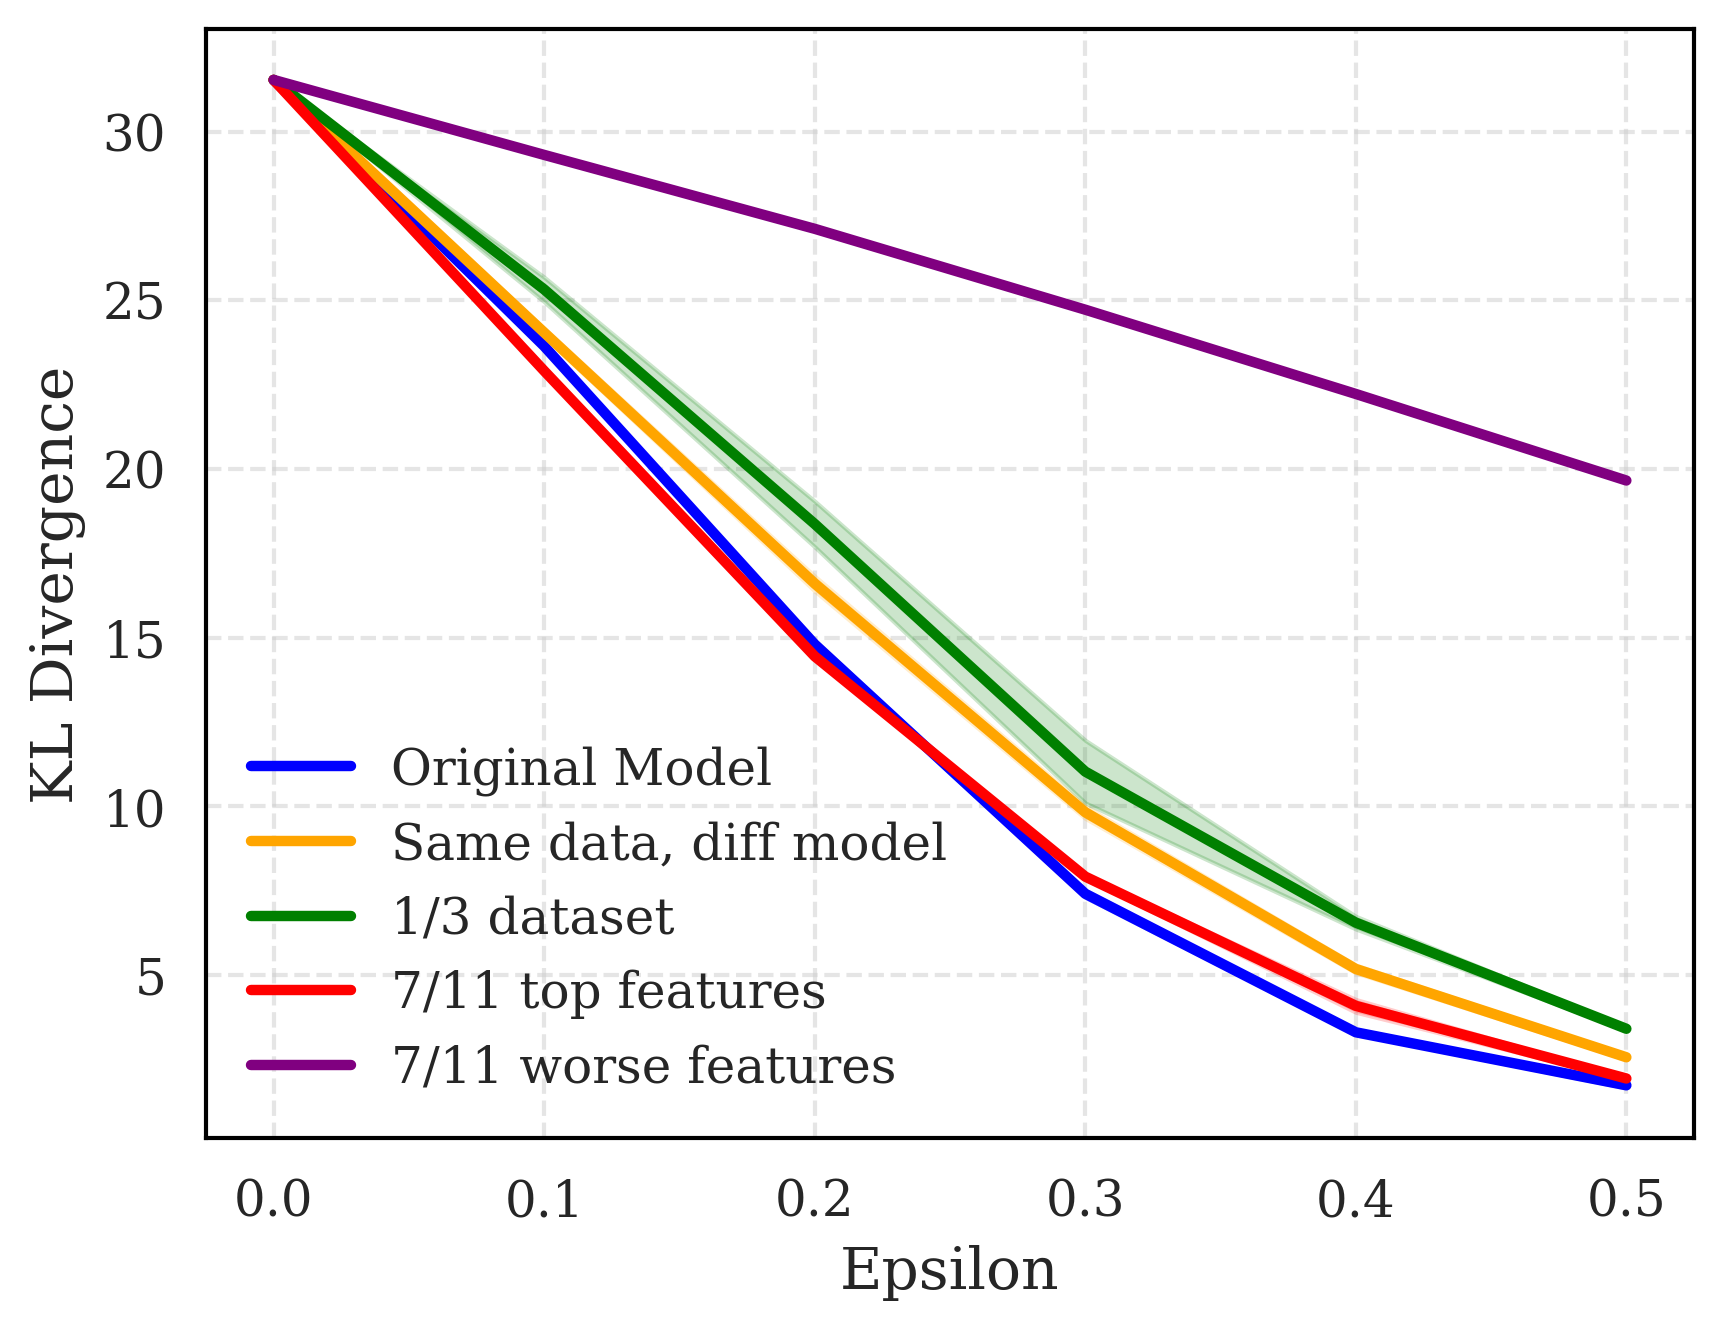

In [13]:
# plot KL divergence as a function of the strength of the attack
n_jobs = 8
x = X_test[17,:].copy().reshape(1, -1)
x = jnp.array(x)
std = model.sample_predictive_distribution(jax.random.PRNGKey(0), x, 1000).std()
mu = model.sample_predictive_distribution(jax.random.PRNGKey(0), x, 1000).mean()
appd = numpyro.distributions.Normal(2 * mu, 2 * std)

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon, at_model):
    if at_model == attack_model3:
        x3 = x[:, TOP_FEATURES].copy()
        x_adv3, _ = mlmc_attack(at_model, x3, appd, epsilon=epsilon, R=10, lr=0.001, n_iter=1000, verbose=False)
        x_adv_distr = x.copy()
        x_adv_distr = x_adv_distr.at[:, TOP_FEATURES].set(x_adv3)
    elif at_model == attack_model4:
        x4 = x[:, WORSE_FEATURES].copy()
        x_adv4, _ = mlmc_attack(at_model, x4, appd, epsilon=epsilon, R=10, lr=0.001, n_iter=1000, verbose=False)
        x_adv_distr = x.copy()
        x_adv_distr = x_adv_distr.at[:, WORSE_FEATURES].set(x_adv4)
    else:
        x_adv_distr, _ = mlmc_attack(at_model, x, appd, epsilon=epsilon, R=10, lr=0.001, n_iter=1000, verbose=False)
    mu_adv = model.sample_predictive_distribution(jax.random.PRNGKey(0), x_adv_distr, 1000).mean()
    sigma2_adv = model.sample_predictive_distribution(jax.random.PRNGKey(0), x_adv_distr, 1000).var()
    return kl_to_appd(mu_adv, sigma2_adv, 2 * mu, 4 * std ** 2).item()


# Define the range of epsilon values
epsilons = np.linspace(0, .5, 6)
kl_all_original = []
kl_all_attack1 = []
kl_all_attack2 = []
kl_all_attack3 = []
kl_all_attack4 = []

num_repeats = 4
for _ in range(num_repeats):
    print(_)
    # Use joblib to parallelize the computation of KL divergences
    #kl_values = Parallel(n_jobs=n_jobs)(delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons)
    kl_values = []
    kl_values_attack1 = []
    kl_values_attack2 = []
    kl_values_attack3 = []
    kl_values_attack4 = []
    for epsilon in epsilons:
        kl_values.append(compute_kl_divergence(epsilon, model))
        kl_values_attack1.append(compute_kl_divergence(epsilon, attack_model1))
        kl_values_attack2.append(compute_kl_divergence(epsilon, attack_model2))
        kl_values_attack3.append(compute_kl_divergence(epsilon, attack_model3))
        kl_values_attack4.append(compute_kl_divergence(epsilon, attack_model4))
    kl_all_original.append(kl_values)
    kl_all_attack1.append(kl_values_attack1)
    kl_all_attack2.append(kl_values_attack2)
    kl_all_attack3.append(kl_values_attack3)
    kl_all_attack4.append(kl_values_attack4)

kl_original_mean = np.mean(kl_all_original, axis=0)
kl_original_std = np.std(kl_all_original, axis=0)
kl_attack1_mean = np.mean(kl_all_attack1, axis=0)
kl_attack1_std = np.std(kl_all_attack1, axis=0)
kl_attack2_mean = np.mean(kl_all_attack2, axis=0)
kl_attack2_std = np.std(kl_all_attack2, axis=0)
kl_attack3_mean = np.mean(kl_all_attack3, axis=0)
kl_attack3_std = np.std(kl_all_attack3, axis=0)
kl_attack4_mean = np.mean(kl_all_attack4, axis=0)
kl_attack4_std = np.std(kl_all_attack4, axis=0)
# Plot the KL divergence as a function of epsilon

plt.plot(epsilons, kl_original_mean, label='Original Model', color='blue')
plt.fill_between(epsilons, kl_original_mean - kl_original_std, kl_original_mean + kl_original_std, color='blue', alpha=0.2)
plt.plot(epsilons, kl_attack1_mean, label='Same data, diff model', color='orange')
plt.fill_between(epsilons, kl_attack1_mean - kl_attack1_std, kl_attack1_mean + kl_attack1_std, color='orange', alpha=0.2)
plt.plot(epsilons, kl_attack2_mean, label='1/3 dataset', color='green')
plt.fill_between(epsilons, kl_attack2_mean - kl_attack2_std, kl_attack2_mean + kl_attack2_std, color='green', alpha=0.2)
plt.plot(epsilons, kl_attack3_mean, label='7/11 top features', color='red')
plt.fill_between(epsilons, kl_attack3_mean - kl_attack3_std, kl_attack3_mean + kl_attack3_std, color='red', alpha=0.2)
plt.plot(epsilons, kl_attack4_mean, label='7/11 worse features', color='purple')
plt.fill_between(epsilons, kl_attack4_mean - kl_attack4_std, kl_attack4_mean + kl_attack4_std, color='purple', alpha=0.2)
plt.xlabel('Epsilon')
plt.ylabel('KL Divergence')

plt.legend()

<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:13: SyntaxWarning: invalid escape sequence '\e'
/var/folders/xf/gv8n8flx2xv_bvk7b5qpnnsm0000gn/T/ipykernel_54017/3350232084.py:13: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


Text(0, 0.5, 'KL Divergence')

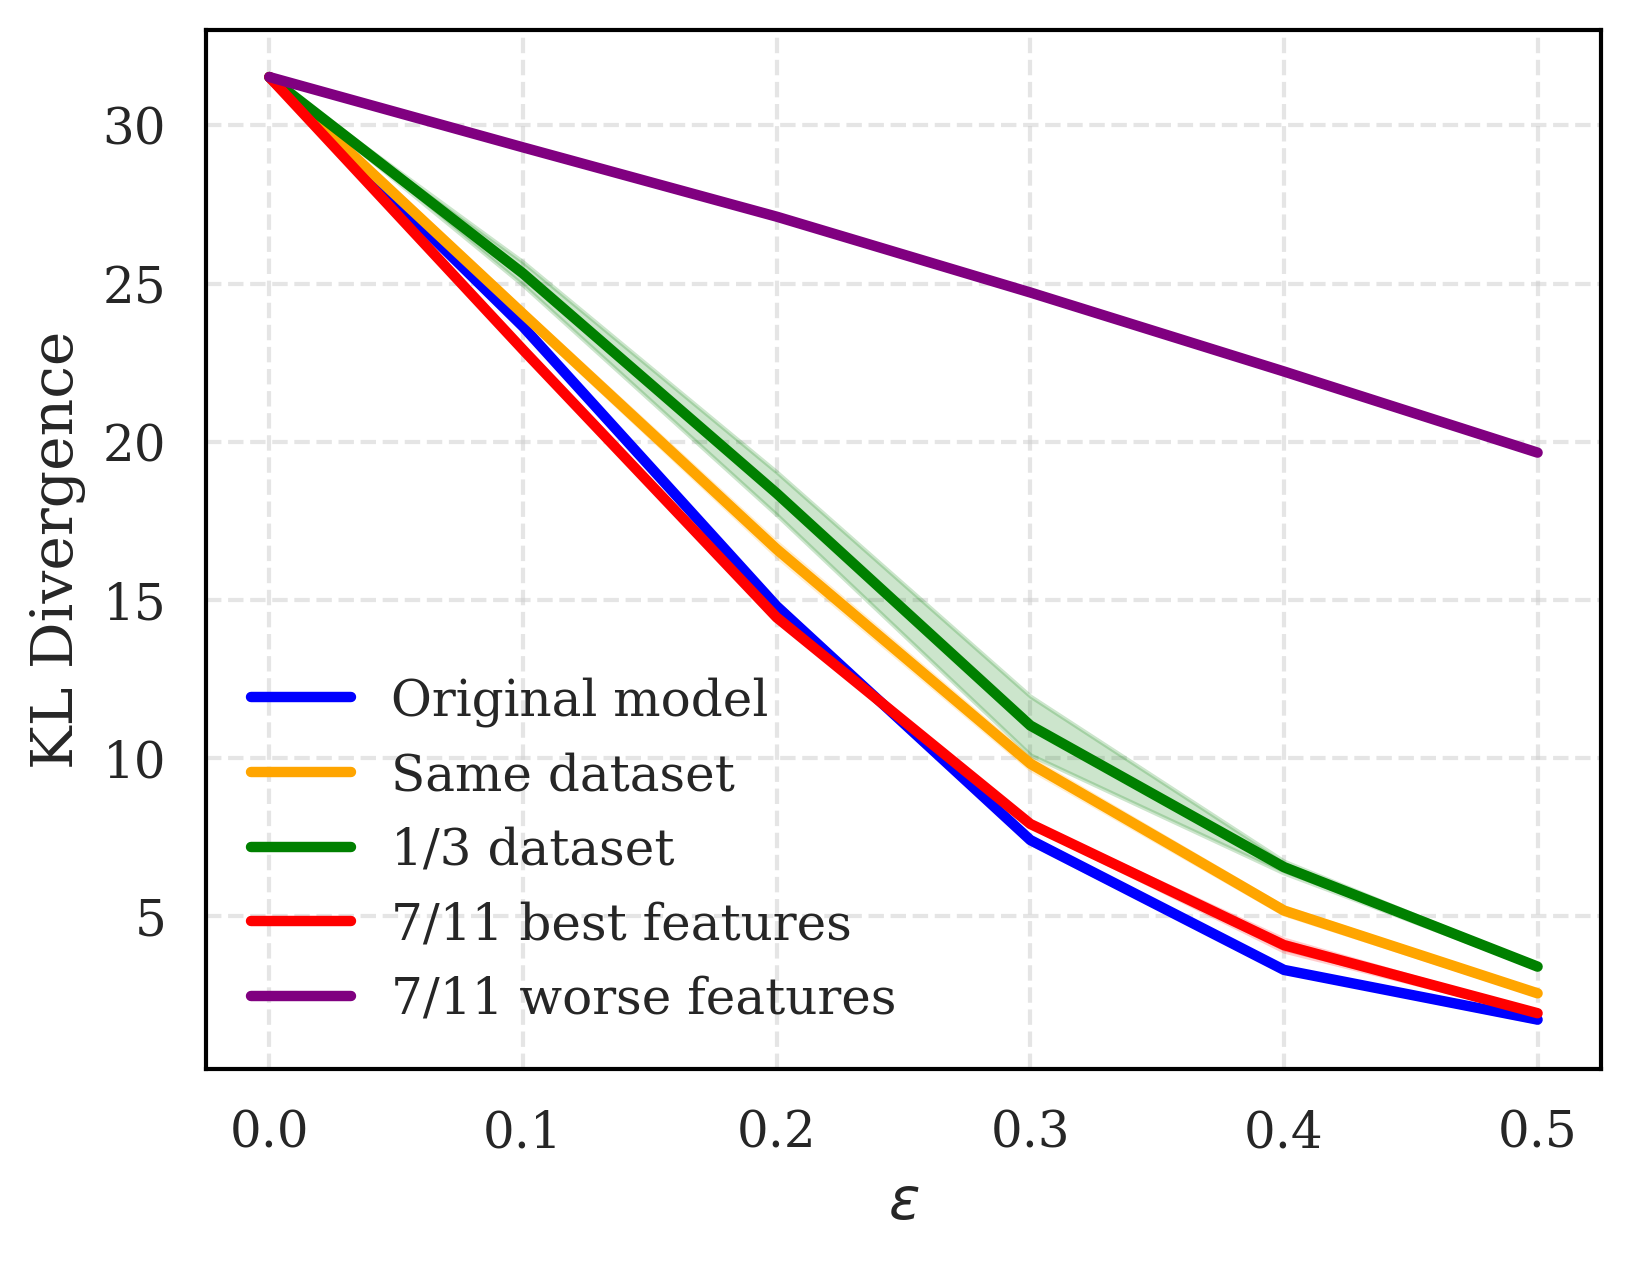

In [17]:
plt.figure(figsize=(6, 4.5))
plt.plot(epsilons, kl_original_mean, label='Original model', color='blue')
plt.fill_between(epsilons, kl_original_mean - kl_original_std, kl_original_mean + kl_original_std, color='blue', alpha=0.2)
plt.plot(epsilons, kl_attack1_mean, label='Same dataset', color='orange')
plt.fill_between(epsilons, kl_attack1_mean - kl_attack1_std, kl_attack1_mean + kl_attack1_std, color='orange', alpha=0.2)
plt.plot(epsilons, kl_attack2_mean, label='1/3 dataset', color='green')
plt.fill_between(epsilons, kl_attack2_mean - kl_attack2_std, kl_attack2_mean + kl_attack2_std, color='green', alpha=0.2)
plt.plot(epsilons, kl_attack3_mean, label='7/11 best features', color='red')
plt.fill_between(epsilons, kl_attack3_mean - kl_attack3_std, kl_attack3_mean + kl_attack3_std, color='red', alpha=0.2)
plt.plot(epsilons, kl_attack4_mean, label='7/11 worse features', color='purple')
plt.fill_between(epsilons, kl_attack4_mean - kl_attack4_std, kl_attack4_mean + kl_attack4_std, color='purple', alpha=0.2)
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')

In [15]:
# Print results 
print('Epsilons:', np.round(epsilons, 2))
print(f'KL Original Mean: {np.round(kl_original_mean, 2)} ± {np.round(kl_original_std, 2)}')
print(f'KL Same data, diff model: {np.round(kl_attack1_mean, 2)} ± {np.round(kl_attack1_std, 2)}')
print(f'KL 1/3 dataset: {np.round(kl_attack2_mean, 2)} ± {np.round(kl_attack2_std, 2)}')
print(f'KL 7/11 top features: {np.round(kl_attack3_mean, 2)} ± {np.round(kl_attack3_std, 2)}')
print(f'KL 7/11 worse features: {np.round(kl_attack4_mean, 2)} ± {np.round(kl_attack4_std, 2)}')

Epsilons: [0.  0.1 0.2 0.3 0.4 0.5]
KL Original Mean: [31.53 23.64 14.8   7.41  3.3   1.73] ± [0.   0.05 0.12 0.11 0.05 0.08]
KL Same data, diff model: [31.53 24.04 16.6   9.82  5.18  2.56] ± [0.   0.12 0.22 0.18 0.11 0.06]
KL 1/3 dataset: [31.53 25.32 18.37 11.03  6.55  3.41] ± [0.   0.36 0.68 0.93 0.19 0.05]
KL 7/11 top features: [31.53 22.91 14.45  7.92  4.09  1.93] ± [0.   0.08 0.04 0.05 0.19 0.03]
KL 7/11 worse features: [31.53 29.31 27.12 24.72 22.22 19.66] ± [0.   0.01 0.06 0.02 0.04 0.04]
